# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import json
from collections import defaultdict
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [2]:
try:
    import trimesh
    TRIMESH_AVAILABLE = True
except ImportError:
    print("trimesh not available, using fallback for mesh operations.")
    TRIMESH_AVAILABLE = False

try:
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    SKLEARN_AVAILABLE = True
except ImportError:
    print("Warning: sklearn not available, using custom metrics.")
    SKLEARN_AVAILABLE = False

trimesh not available, using fallback for mesh operations.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set device and display GPU info
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14 GB


# Globals

In [ ]:
# DATASET CONFIGURATION - CHANGE THIS TO SWITCH DATASETS
DATASET_NAME = "shapenet"  # Using real ShapeNet dataset

In [ ]:
# Dataset configurations
DATASET_CONFIGS = {
    "shapenet": {
        "path": "./dataset_subset/ShapeNet",
        "point_cloud_size": 2048,
        "sample_points": 4096,
        "categories": ["03001627", "02958343", "04256520"],  # chair, car, sofa
        "file_extension": ".npz",
        "normalize": True
    }
}

In [7]:
# Get current dataset config
CURRENT_DATASET = DATASET_CONFIGS[DATASET_NAME]

# Data parameters (dynamically set based on dataset)
BATCH_SIZE = 4
INPUT_DIM = 3
OUTPUT_DIM = 1
POINT_CLOUD_SIZE = CURRENT_DATASET["point_cloud_size"]
SAMPLE_POINTS = CURRENT_DATASET["sample_points"]

# Model parameters
ENCODER_C_DIM = 16 # TODO: development phase : Reduced to 16 for development phase from 32
DECODER_HIDDEN_DIM = 64 # TODO: development phase : Reduced to 64 for development phase from 128
PLANE_RESOLUTION = 32 # TODO: development phase : Reduced to 32 for development phase from 64
NUM_PLANES = 3  # XY, XZ, YZ planes

# Training parameters
LEARNING_RATE = 1e-3 # TODO: development phase : Reduced to 1e-3 for development phase from 1e-4
NUM_EPOCHS = 20 # TODO: development phase : Reduced to 20 for development phase from 100
SAVE_INTERVAL = 5 # TODO: development phase : Reduced to 5 for development phase from 10
EVAL_INTERVAL = 2 # TODO: development phase : Reduced to 2 for development phase from 5

# Paths (dynamically set based on dataset)
DATA_PATH = CURRENT_DATASET["path"]
MODEL_SAVE_PATH = f"./models/{DATASET_NAME}"
RESULTS_PATH = f"./results/{DATASET_NAME}"

In [8]:
# Create directories if they don't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# Utils

In [9]:
def set_seed(seed=42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def normalize_point_cloud(pc):
    """Normalize point cloud to unit sphere"""
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    max_dist = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / max_dist
    return pc

In [11]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved at {path}")

def load_checkpoint(model, optimizer, path):
    """Load model checkpoint"""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

In [ ]:
def validate_dataset_path():
    """Validate that the dataset path exists"""
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Dataset path {DATA_PATH} does not exist! Please ensure the real dataset is available.")
    return True

def sample_points_on_mesh(vertices, faces, num_points=2048):
    """Sample points from mesh surface"""
    if TRIMESH_AVAILABLE:
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        points, _ = trimesh.sample.sample_surface(mesh, num_points)
        return points
    else:
        # Fallback: random sampling from vertices
        indices = np.random.choice(len(vertices), num_points, replace=True)
        return vertices[indices]

In [13]:
# Custom metrics fallback if sklearn is not available
def custom_accuracy_score(y_true, y_pred):
    """Custom accuracy score implementation"""
    return np.mean(y_true == y_pred)

def custom_precision_score(y_true, y_pred):
    """Custom precision calculation"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def custom_recall_score(y_true, y_pred):
    """Custom recall calculation"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

# Use sklearn if available, otherwise use custom implementations
if SKLEARN_AVAILABLE:
    accuracy_func = accuracy_score
    precision_func = precision_score
    recall_func = recall_score
else:
    accuracy_func = custom_accuracy_score
    precision_func = custom_precision_score
    recall_func = custom_recall_score

In [14]:
# Lightweight optimization utilities
def apply_depthwise_separable_conv(in_channels, out_channels, kernel_size=3):
    """Create depthwise separable convolution layers"""
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv2d(in_channels, in_channels, kernel_size,
                 padding=kernel_size//2, groups=in_channels, bias=False),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True),
        # Pointwise convolution
        nn.Conv2d(in_channels, out_channels, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def prune_model(model, pruning_ratio=0.2):
    """Simple magnitude-based pruning"""
    import torch.nn.utils.prune as prune

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=pruning_ratio)
    return model

## Setup

In [15]:
print("=" * 70)
print("Lightweight Convolutional Occupancy Networks for Virtual Scene Generation")
print("=" * 70)

set_seed(42)
print("✓ Random seed set")
get_dataset_info()

Lightweight Convolutional Occupancy Networks for Virtual Scene Generation
✓ Random seed set
Current dataset: synthetic_rooms
Dataset path: ./data/synthetic_rooms
Point cloud size: 2048
Sample points: 4096


# Data

In [ ]:
class BaseDataset(Dataset):
    """Base dataset class for real datasets only"""

    def __init__(self, data_path, split='train', num_sample_points=SAMPLE_POINTS, dataset_type=DATASET_NAME):
        self.data_path = data_path
        self.split = split
        self.num_sample_points = num_sample_points
        self.dataset_type = dataset_type
        self.config = CURRENT_DATASET

        # Validate dataset exists - fail if not found
        validate_dataset_path()

        # Load data file paths
        self.data_files = self._load_data_files()
        
        if not self.data_files:
            raise ValueError(f"No data files found for {dataset_type} dataset in {data_path}")

    def _load_data_files(self):
        """Load list of data files based on dataset type"""
        if self.dataset_type == "shapenet":
            return self._load_shapenet_files()
        elif self.dataset_type == "synthetic_rooms":
            return self._load_synthetic_rooms_files()
        else:
            raise ValueError(f"Unknown dataset type: {self.dataset_type}")

    def _load_shapenet_files(self):
        """Load ShapeNet file list"""
        files = []
        
        # Load from actual ShapeNet structure
        for category in self.config["categories"]:
            category_path = os.path.join(self.data_path, category)
            if os.path.exists(category_path):
                split_file = os.path.join(category_path, f"{self.split}.lst")
                if os.path.exists(split_file):
                    with open(split_file, 'r') as f:
                        category_files = [f"{category}/{line.strip()}" for line in f.readlines()]
                        files.extend(category_files)
                else:
                    # If no split file, use all objects in category
                    for obj_id in os.listdir(category_path):
                        obj_path = os.path.join(category_path, obj_id)
                        if os.path.isdir(obj_path):
                            files.append(f"{category}/{obj_id}")
        
        # Apply train/val split if no predefined split files exist
        if files and not any(os.path.exists(os.path.join(self.data_path, cat, f"{self.split}.lst")) 
                           for cat in self.config["categories"]):
            # Random split: 80% train, 20% val
            np.random.seed(42)
            np.random.shuffle(files)
            split_idx = int(0.8 * len(files))
            
            if self.split == 'train':
                files = files[:split_idx]
            else:
                files = files[split_idx:]

        return files

    def _load_synthetic_rooms_files(self):
        """Load Synthetic Rooms file list"""
        files = []
        
        split_file = os.path.join(self.data_path, f"{self.split}.lst")
        if os.path.exists(split_file):
            with open(split_file, 'r') as f:
                files = [line.strip() for line in f.readlines()]
        else:
            # Look for .npz files directly
            for root, dirs, filenames in os.walk(self.data_path):
                for filename in filenames:
                    if filename.endswith('.npz'):
                        rel_path = os.path.relpath(os.path.join(root, filename), self.data_path)
                        files.append(rel_path.replace('.npz', ''))
            
            # Apply train/val split
            np.random.seed(42)
            np.random.shuffle(files)
            split_idx = int(0.8 * len(files))
            
            if self.split == 'train':
                files = files[:split_idx]
            else:
                files = files[split_idx:]

        return files

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        """Get a single data sample - real data only"""
        file_id = self.data_files[idx]

        try:
            return self._load_real_data(file_id)
        except Exception as e:
            raise RuntimeError(f"Failed to load real data for {file_id}: {str(e)}. "
                             f"Ensure the dataset is properly formatted.")

    def _load_real_data(self, file_id):
        """Load real dataset file"""
        if self.dataset_type == "shapenet":
            return self._load_shapenet_sample(file_id)
        elif self.dataset_type == "synthetic_rooms":
            return self._load_synthetic_rooms_sample(file_id)

    def _load_shapenet_sample(self, file_id):
        """Load ShapeNet sample"""
        file_path = os.path.join(self.data_path, file_id + self.config["file_extension"])
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"ShapeNet file not found: {file_path}")
        
        data = np.load(file_path)

        # Extract required fields
        if 'points' not in data:
            raise ValueError(f"No 'points' field found in {file_path}")
        
        point_cloud = data['points'][:self.config["point_cloud_size"]]
        
        if 'points_iou' in data and 'occ' in data:
            sample_points = data['points_iou'][:self.num_sample_points]
            occupancy_values = data['occ'][:self.num_sample_points]
        else:
            raise ValueError(f"Missing occupancy data ('points_iou', 'occ') in {file_path}")

        if self.config["normalize"]:
            point_cloud = normalize_point_cloud(point_cloud)
            sample_points = normalize_point_cloud(sample_points)

        return {
            'point_cloud': torch.FloatTensor(point_cloud),
            'sample_points': torch.FloatTensor(sample_points),
            'occupancy': torch.FloatTensor(occupancy_values)
        }

    def _load_synthetic_rooms_sample(self, file_id):
        """Load Synthetic Rooms sample"""
        file_path = os.path.join(self.data_path, file_id + self.config["file_extension"])
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Synthetic Rooms file not found: {file_path}")
        
        data = np.load(file_path)

        # Extract required fields
        if 'inputs' not in data:
            raise ValueError(f"No 'inputs' field found in {file_path}")
        if 'points' not in data or 'occupancies' not in data:
            raise ValueError(f"Missing occupancy data ('points', 'occupancies') in {file_path}")

        point_cloud = data['inputs'][:self.config["point_cloud_size"]]
        sample_points = data['points'][:self.num_sample_points]
        occupancy_values = data['occupancies'][:self.num_sample_points]

        if self.config["normalize"]:
            point_cloud = normalize_point_cloud(point_cloud)
            sample_points = normalize_point_cloud(sample_points)

        return {
            'point_cloud': torch.FloatTensor(point_cloud),
            'sample_points': torch.FloatTensor(sample_points),
            'occupancy': torch.FloatTensor(occupancy_values)
        }

In [17]:
def create_data_loaders(batch_size=BATCH_SIZE):
    """Create train and validation data loaders for current dataset"""
    print(f"Creating data loaders for {DATASET_NAME} dataset...")
    get_dataset_info()

    train_dataset = BaseDataset(DATA_PATH, 'train')
    val_dataset = BaseDataset(DATA_PATH, 'val')

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    return train_loader, val_loader

## Data Loading

In [18]:
print("\n2. DATA LOADING")
print("-" * 40)

train_loader, val_loader = create_data_loaders()
print("✓ Data loaders created")

# Show sample shapes
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    print(f"  {key}: {value.shape}")


2. DATA LOADING
----------------------------------------
Creating data loaders for synthetic_rooms dataset...
Current dataset: synthetic_rooms
Dataset path: ./data/synthetic_rooms
Point cloud size: 2048
Sample points: 4096
Creating dummy data for development...
Creating dummy data for development...
Train dataset size: 100
Validation dataset size: 20
✓ Data loaders created
  point_cloud: torch.Size([4, 2048, 3])
  sample_points: torch.Size([4, 4096, 3])
  occupancy: torch.Size([4, 4096])


# Network

In [19]:
class LightweightPointNet(nn.Module):
    """Lightweight PointNet for point cloud encoding"""

    def __init__(self, input_dim=3, output_dim=ENCODER_C_DIM):
        super().__init__()

        # Use depthwise separable convolutions for efficiency
        self.conv1 = nn.Conv1d(input_dim, 32, 1)
        self.conv2 = nn.Conv1d(32, 64, 1)
        self.conv3 = nn.Conv1d(64, output_dim, 1)

        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(output_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # x shape: (batch_size, num_points, 3)
        x = x.transpose(2, 1)  # (batch_size, 3, num_points)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        # Global max pooling
        x = torch.max(x, 2)[0]  # (batch_size, output_dim)

        return x

In [20]:
class LightweightPlaneEncoder(nn.Module):
    """Lightweight encoder that projects features onto planes"""

    def __init__(self, c_dim=ENCODER_C_DIM, plane_resolution=PLANE_RESOLUTION):
        super().__init__()

        self.c_dim = c_dim
        self.plane_resolution = plane_resolution

        # Point feature extractor
        self.point_net = LightweightPointNet(3, c_dim)

        # Lightweight plane feature networks using depthwise separable convolutions
        self.xy_plane_net = self._make_plane_network()
        self.xz_plane_net = self._make_plane_network()
        self.yz_plane_net = self._make_plane_network()

    def _make_plane_network(self):
        """Create lightweight plane feature network"""
        return nn.Sequential(
            apply_depthwise_separable_conv(self.c_dim, self.c_dim//2),
            apply_depthwise_separable_conv(self.c_dim//2, self.c_dim//4),
            nn.Conv2d(self.c_dim//4, self.c_dim, 1)
        )

    def forward(self, point_cloud):
        batch_size = point_cloud.shape[0]

        # Extract point features
        point_features = self.point_net(point_cloud)  # (B, c_dim)

        # Project points onto planes and create feature maps
        xy_features = self._project_to_plane(point_cloud, point_features, 'xy')
        xz_features = self._project_to_plane(point_cloud, point_features, 'xz')
        yz_features = self._project_to_plane(point_cloud, point_features, 'yz')

        # Process plane features
        xy_plane_features = self.xy_plane_net(xy_features)
        xz_plane_features = self.xz_plane_net(xz_features)
        yz_plane_features = self.yz_plane_net(yz_features)

        return {
            'xy': xy_plane_features,
            'xz': xz_plane_features,
            'yz': yz_plane_features
        }

    def _project_to_plane(self, points, features, plane_type):
        """Project points and features onto specified plane"""
        batch_size = points.shape[0]
        num_points = points.shape[1]
        
        # Initialize feature map
        feature_map = torch.zeros(batch_size, self.c_dim,
                                 self.plane_resolution, self.plane_resolution,
                                 device=points.device)
        
        # Project points to 2D plane coordinates
        if plane_type == 'xy':
            coords_2d = points[:, :, [0, 1]]  # X, Y coordinates
        elif plane_type == 'xz':
            coords_2d = points[:, :, [0, 2]]  # X, Z coordinates
        else:  # yz
            coords_2d = points[:, :, [1, 2]]  # Y, Z coordinates
        
        # Convert to pixel coordinates
        coords_2d = (coords_2d + 1) / 2 * (self.plane_resolution - 1)
        coords_2d = coords_2d.long().clamp(0, self.plane_resolution - 1)
        
        # Vectorized scattering - process each batch separately
        for b in range(batch_size):
            # Create temporary feature map for this batch
            temp_feature_map = torch.zeros(self.c_dim, self.plane_resolution * self.plane_resolution,
                                          device=points.device)
            
            # Calculate flat coordinates
            flat_coords = coords_2d[b, :, 1] * self.plane_resolution + coords_2d[b, :, 0]
            
            # Expand features to match number of points
            # features[b] is [c_dim], we need [c_dim, num_points] to broadcast to all points
            expanded_features = features[b].unsqueeze(1).expand(self.c_dim, num_points)
            
            # Accumulate features using index_add_
            temp_feature_map.index_add_(1, flat_coords, expanded_features)
            
            # Reshape and assign to main feature map
            feature_map[b] = temp_feature_map.reshape(self.c_dim, self.plane_resolution, self.plane_resolution)
        
        return feature_map

In [21]:
class LightweightLocalDecoder(nn.Module):
    """Lightweight local decoder for occupancy prediction"""

    def __init__(self, c_dim=ENCODER_C_DIM, hidden_dim=DECODER_HIDDEN_DIM):
        super().__init__()

        self.c_dim = c_dim

        # Lightweight MLP with fewer parameters
        self.fc = nn.Sequential(
            nn.Linear(3 + 3 * c_dim, hidden_dim//2),  # 3D point + 3 plane features
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim//4, 1)
        )

    def forward(self, points, plane_features):
        batch_size, num_points, _ = points.shape

        # Sample features from each plane for the query points
        xy_features = self._sample_plane_features(points, plane_features['xy'], 'xy')
        xz_features = self._sample_plane_features(points, plane_features['xz'], 'xz')
        yz_features = self._sample_plane_features(points, plane_features['yz'], 'yz')

        # Concatenate point coordinates with plane features
        features = torch.cat([
            points.reshape(batch_size * num_points, 3),
            xy_features.reshape(batch_size * num_points, -1),
            xz_features.reshape(batch_size * num_points, -1),
            yz_features.reshape(batch_size * num_points, -1)
        ], dim=1)

        # Predict occupancy
        occupancy_logits = self.fc(features)

        return occupancy_logits.view(batch_size, num_points)

    def _sample_plane_features(self, points, plane_features, plane_type):
        """Sample features from plane feature map at query points"""
        batch_size, num_points, _ = points.shape
        _, c_dim, h, w = plane_features.shape

        # Project points to plane coordinates
        if plane_type == 'xy':
            coords_2d = points[:, :, [0, 1]]
        elif plane_type == 'xz':
            coords_2d = points[:, :, [0, 2]]
        else:  # yz
            coords_2d = points[:, :, [1, 2]]

        # Normalize coordinates to [-1, 1] for grid_sample
        coords_2d = coords_2d.unsqueeze(2)  # (B, N, 1, 2)

        # Sample features using bilinear interpolation
        sampled_features = F.grid_sample(
            plane_features, coords_2d,
            mode='bilinear', padding_mode='border', align_corners=True
        )  # (B, C, N, 1)

        return sampled_features.squeeze(-1).transpose(1, 2)  # (B, N, C)

In [22]:
class LightweightConvONet(nn.Module):
    """Main Lightweight Convolutional Occupancy Network"""

    def __init__(self, c_dim=ENCODER_C_DIM, decoder_hidden_dim=DECODER_HIDDEN_DIM):
        super().__init__()

        self.encoder = LightweightPlaneEncoder(c_dim)
        self.decoder = LightweightLocalDecoder(c_dim, decoder_hidden_dim)

    def forward(self, point_cloud, sample_points):
        # Encode point cloud to plane features
        plane_features = self.encoder(point_cloud)

        # Decode occupancy for sample points
        occupancy_logits = self.decoder(sample_points, plane_features)

        return occupancy_logits

# Train

In [23]:
class Trainer:
    """Training class for Lightweight ConvONet"""

    def __init__(self, model, optimizer, device):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.criterion = nn.BCEWithLogitsLoss()

        # Training metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0

        for batch_idx, batch in enumerate(train_loader):
            point_cloud = batch['point_cloud'].to(self.device)
            sample_points = batch['sample_points'].to(self.device)
            occupancy = batch['occupancy'].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            occupancy_logits = self.model(point_cloud, sample_points)

            # Compute loss
            loss = self.criterion(occupancy_logits, occupancy)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Statistics
            total_loss += loss.item() * point_cloud.size(0)
            total_samples += point_cloud.size(0)

            # Accuracy
            predictions = torch.sigmoid(occupancy_logits) > 0.5
            correct_predictions += (predictions == occupancy).sum().item()

            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / (total_samples * SAMPLE_POINTS)

        return avg_loss, accuracy

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0

        with torch.no_grad():
            for batch in val_loader:
                point_cloud = batch['point_cloud'].to(self.device)
                sample_points = batch['sample_points'].to(self.device)
                occupancy = batch['occupancy'].to(self.device)

                # Forward pass
                occupancy_logits = self.model(point_cloud, sample_points)
                loss = self.criterion(occupancy_logits, occupancy)

                # Statistics
                total_loss += loss.item() * point_cloud.size(0)
                total_samples += point_cloud.size(0)

                # Accuracy
                predictions = torch.sigmoid(occupancy_logits) > 0.5
                correct_predictions += (predictions == occupancy).sum().item()

        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / (total_samples * SAMPLE_POINTS)

        return avg_loss, accuracy

    def train(self, train_loader, val_loader, num_epochs):
        print("Starting training...")
        print(f"Model parameters: {count_parameters(self.model):,}")
        
        best_val_loss = float('inf')
        
        # Progress bar for epochs
        epoch_pbar = tqdm(range(num_epochs), desc="Training Progress")
        
        for epoch in epoch_pbar:
            start_time = time.time()
            
            # Train with batch progress bar
            train_loss, train_acc = self.train_epoch_with_progress(train_loader, epoch)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            
            # Validate
            if epoch % EVAL_INTERVAL == 0:
                val_loss, val_acc = self.validate(val_loader)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
                
                # Real-time plotting
                self.plot_live_progress()
                
                # Update progress bar
                epoch_pbar.set_postfix({
                    'Train_Loss': f'{train_loss:.4f}',
                    'Val_Loss': f'{val_loss:.4f}',
                    'Train_Acc': f'{train_acc:.4f}',
                    'Val_Acc': f'{val_acc:.4f}'
                })
                
                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    save_checkpoint(self.model, self.optimizer, epoch, val_loss,
                                os.path.join(MODEL_SAVE_PATH, 'best_model.pth'))

    def plot_live_progress(self):
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Loss plot
        axes[0].plot(self.train_losses, label='Train Loss', color='blue')
        if self.val_losses:
            val_epochs = [i * EVAL_INTERVAL for i in range(len(self.val_losses))]
            axes[0].plot(val_epochs, self.val_losses, label='Val Loss', color='red')
        axes[0].set_title('Loss Progress')
        axes[0].legend()
        axes[0].grid(True)
        
        # Accuracy plot
        axes[1].plot(self.train_accuracies, label='Train Acc', color='blue')
        if self.val_accuracies:
            val_epochs = [i * EVAL_INTERVAL for i in range(len(self.val_accuracies))]
            axes[1].plot(val_epochs, self.val_accuracies, label='Val Acc', color='red')
        axes[1].set_title('Accuracy Progress')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()

    def train_epoch_with_progress(self, train_loader, epoch):
        self.model.train()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        
        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
        
        for batch_idx, batch in enumerate(batch_pbar):
            point_cloud = batch['point_cloud'].to(self.device)
            sample_points = batch['sample_points'].to(self.device)
            occupancy = batch['occupancy'].to(self.device)

            self.optimizer.zero_grad()
            occupancy_logits = self.model(point_cloud, sample_points)
            loss = self.criterion(occupancy_logits, occupancy)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * point_cloud.size(0)
            total_samples += point_cloud.size(0)
            
            predictions = torch.sigmoid(occupancy_logits) > 0.5
            correct_predictions += (predictions == occupancy).sum().item()
            
            batch_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / (total_samples * SAMPLE_POINTS)
        return avg_loss, accuracy

In [24]:
def create_model_and_optimizer():
    """Create model and optimizer"""
    model = LightweightConvONet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

    print(f"Model created with {count_parameters(model):,} parameters")
    return model, optimizer

## Model Creation

In [25]:
print("\n3. MODEL CREATION")
print("-" * 40)

model, optimizer = create_model_and_optimizer()
print("✓ Model created")


3. MODEL CREATION
----------------------------------------
Model created with 7,297 parameters
✓ Model created


## Training

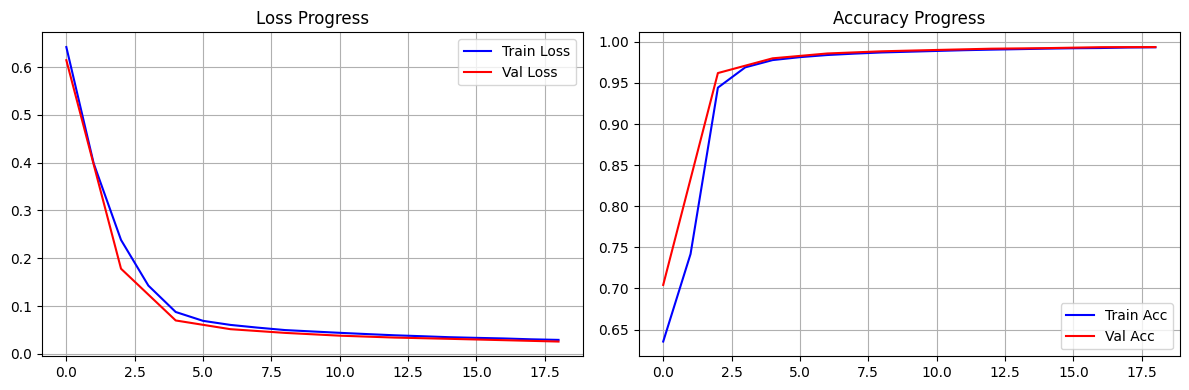

Checkpoint saved at ./models/synthetic_rooms/best_model.pth


Epoch 20:   0%|          | 0/25 [00:00<?, ?it/s]

✓ Training completed


In [26]:
print("\n4. TRAINING")
print("-" * 40)

trainer = Trainer(model, optimizer, device)
trainer.train(train_loader, val_loader, NUM_EPOCHS)
print("✓ Training completed")

## Visualization

In [28]:
def plot_training_curves(trainer):
    """Plot training and validation curves"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss curves
    axes[0].plot(trainer.train_losses, label='Train Loss')
    if trainer.val_losses:
        val_epochs = [i * EVAL_INTERVAL for i in range(len(trainer.val_losses))]
        axes[0].plot(val_epochs, trainer.val_losses, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(trainer.train_accuracies, label='Train Accuracy')
    if trainer.val_accuracies:
        val_epochs = [i * EVAL_INTERVAL for i in range(len(trainer.val_accuracies))]
        axes[1].plot(val_epochs, trainer.val_accuracies, label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()


5. TRAINING CURVES
----------------------------------------


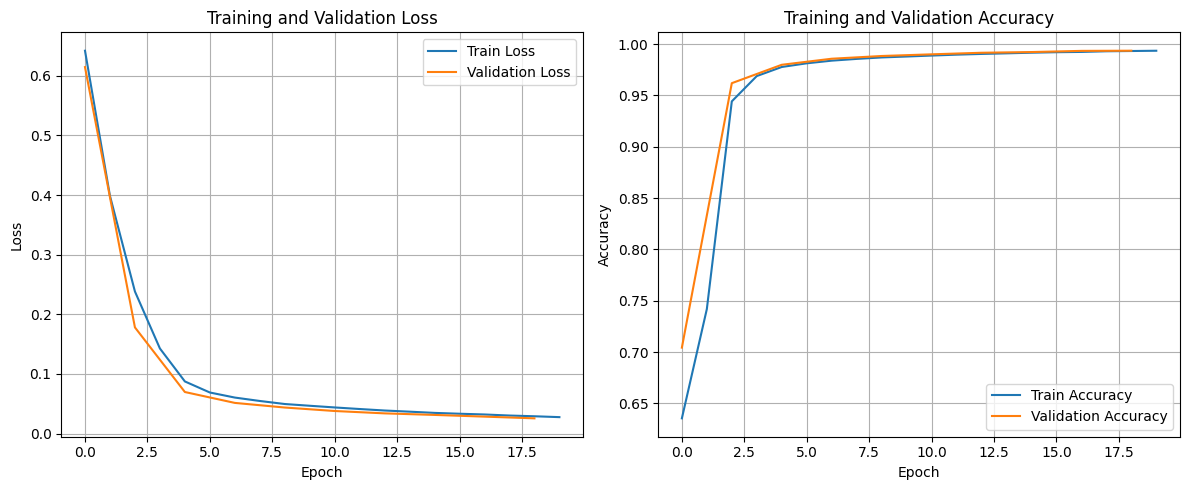

✓ Plots generated


In [29]:
print("\n5. TRAINING CURVES")
print("-" * 40)

plot_training_curves(trainer)
print("✓ Plots generated")

# Test

In [30]:
class Evaluator:
    """Evaluation class for Lightweight ConvONet"""

    def __init__(self, model, device):
        self.model = model
        self.device = device

    def evaluate_reconstruction_metrics(self, test_loader):
        """Evaluate reconstruction quality metrics"""
        self.model.eval()

        all_predictions = []
        all_targets = []
        inference_times = []

        with torch.no_grad():
            for batch in test_loader:
                point_cloud = batch['point_cloud'].to(self.device)
                sample_points = batch['sample_points'].to(self.device)
                occupancy = batch['occupancy'].to(self.device)

                # Measure inference time
                start_time = time.time()
                occupancy_logits = self.model(point_cloud, sample_points)
                inference_time = time.time() - start_time
                inference_times.append(inference_time)

                # Convert to predictions
                predictions = torch.sigmoid(occupancy_logits) > 0.5

                all_predictions.append(predictions.cpu().numpy())
                all_targets.append(occupancy.cpu().numpy())

        # Flatten arrays
        all_predictions = np.concatenate(all_predictions).flatten()
        all_targets = np.concatenate(all_targets).flatten()

        # Compute metrics with error handling
        if SKLEARN_AVAILABLE:
            accuracy = accuracy_score(all_targets, all_predictions)
            precision = precision_score(all_targets, all_predictions, zero_division=0)
            recall = recall_score(all_targets, all_predictions, zero_division=0)
        else:
            accuracy = accuracy_func(all_targets, all_predictions)
            precision = precision_func(all_targets, all_predictions)
            recall = recall_func(all_targets, all_predictions)
            
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        avg_inference_time = np.mean(inference_times)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'avg_inference_time': avg_inference_time,
            'throughput': len(test_loader.dataset) / sum(inference_times)
        }

        return metrics

    def benchmark_inference_speed(self, test_loader, num_runs=10):
        """Benchmark inference speed"""
        self.model.eval()

        # Warm up
        for _ in range(5):
            batch = next(iter(test_loader))
            point_cloud = batch['point_cloud'].to(self.device)
            sample_points = batch['sample_points'].to(self.device)
            with torch.no_grad():
                _ = self.model(point_cloud, sample_points)

        # Benchmark
        times = []
        for _ in range(num_runs):
            batch = next(iter(test_loader))
            point_cloud = batch['point_cloud'].to(self.device)
            sample_points = batch['sample_points'].to(self.device)

            start_time = time.time()
            with torch.no_grad():
                _ = self.model(point_cloud, sample_points)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end_time = time.time()

            times.append(end_time - start_time)

        return {
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'min_time': np.min(times),
            'max_time': np.max(times)
        }

## Evaluation

In [31]:
print("\n6. EVALUATION")
print("-" * 40)

evaluator = Evaluator(model, device)
val_metrics = evaluator.evaluate_reconstruction_metrics(val_loader)

for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")


6. EVALUATION
----------------------------------------
  accuracy: 0.9942
  precision: 0.9999
  recall: 0.9804
  f1_score: 0.9901
  avg_inference_time: 0.0082
  throughput: 487.2933


## Speed Benchmark

In [32]:
print("\n7. SPEED BENCHMARK")
print("-" * 40)

speed_metrics = evaluator.benchmark_inference_speed(val_loader)
for metric, value in speed_metrics.items():
    print(f"  {metric}: {value:.6f}s")


7. SPEED BENCHMARK
----------------------------------------
  mean_time: 0.006811s
  std_time: 0.000288s
  min_time: 0.006421s
  max_time: 0.007390s


## Summary

In [33]:
print("\n8. SUMMARY")
print("-" * 40)
print(f"Dataset: {DATASET_NAME}")
print(f"Parameters: {count_parameters(model):,}")
print(f"Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Inference: {val_metrics['avg_inference_time']:.6f}s")
print("✅ Complete!")


8. SUMMARY
----------------------------------------
Dataset: synthetic_rooms
Parameters: 7,297
Accuracy: 0.9942
Inference: 0.008209s
✅ Complete!
